### Partie 2 : Analyse exploratoire des données et clustering

In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
from math import exp, sqrt, pi
from scipy.stats import chi2_contingency, pearsonr

In [18]:
complete = pd.read_csv('complete.csv')
complete = complete.drop(columns=['Unnamed: 0'])

complete.head()

,Zone,Disponibilité alimentaire volailles (Kcal/personne/jour),Disponibilité de protéines (g/personne/jour),Importations volailles (milliers tonnes),Production volailles (milliers tonnes),Disponibilité alimentaire totale (Kcal/personne/jour),PIB / Habitant ($),Stabilité politique (indice),Evolution Pop % (2000-2017)
0,Afghanistan,5.0,0.54,29.0,28.0,2266.0,2058.4,-2.80,75.0
1,Afrique du Sud,143.0,14.11,514.0,1667.0,2902.0,13860.3,-0.28,27.0
2,Albanie,85.0,6.26,38.0,13.0,3314.0,12771.0,0.38,-8.0
3,Algérie,22.0,1.97,2.0,275.0,3402.0,11737.4,-0.92,33.0
4,Allemagne,71.0,7.96,842.0,1514.0,3551.0,53071.5,0.59,2.0


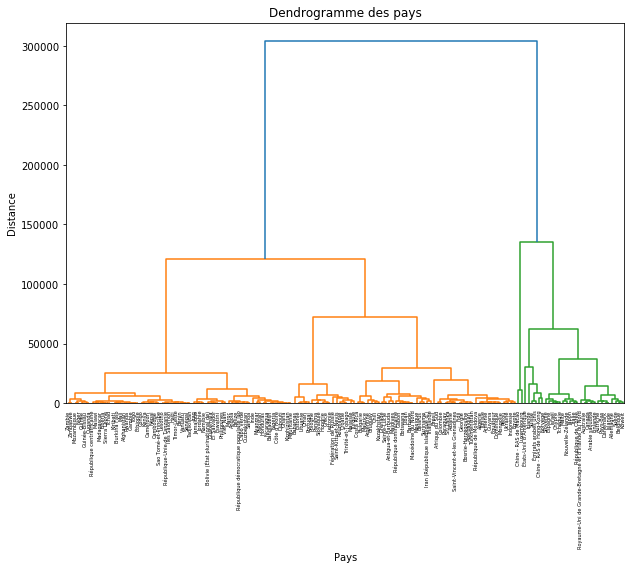

In [19]:
# Réalisation d'un dendogramme en fonction des variables quantitatives du dataframe 'complete'

df = complete

quantitative_vars = ['Disponibilité alimentaire volailles (Kcal/personne/jour)',
                     'Disponibilité de protéines (g/personne/jour)',
                     'Importations volailles (milliers tonnes)',
                     'Production volailles (milliers tonnes)',
                     'Disponibilité alimentaire totale (Kcal/personne/jour)',
                     'PIB / Habitant ($)',
                     'Stabilité politique (indice)',
                     'Evolution Pop % (2000-2017)']

data_for_dendrogram = df[quantitative_vars]

# Calcul de la matrice de distance entre les observations et
# réalisation d'un clustering hiérarchique sur ces distances pour former le dendrogramme
# La méthode de liaison ward permet de former des clusters en minimisant les différences à l'intérieur de chaque cluster
distance_matrix = hierarchy.distance.pdist(data_for_dendrogram, metric='euclidean')
linkage_matrix = hierarchy.linkage(distance_matrix, method='ward')

plt.figure(figsize=(10, 7))
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=df['Zone'].tolist())
plt.title('Dendrogramme des pays')
plt.xlabel('Pays')
plt.ylabel('Distance')
plt.show()

In [ ]:
# A corriger : Faire l'ACP sur les clusters de pays pour avoir une visualitation plus fine des résulats 

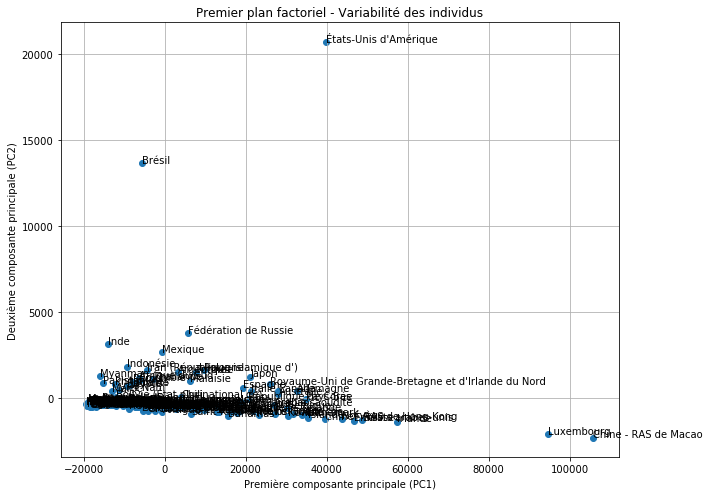

In [13]:
# Sélectionner les colonnes des variables pour l'ACP (à l'exclusion de la colonne 'Zone')
variables = complete.drop(columns=['Zone'])

# Réaliser l'ACP en utilisant la librairie sklearn
pca = PCA(n_components=2)
pca_result = pca.fit_transform(variables)

# Créer un DataFrame pour visualiser les individus dans le premier plan factoriel
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Zone'] = complete['Zone']

# Visualisation des individus dans le premier plan factoriel
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
for i, zone in enumerate(pca_df['Zone']):
    plt.text(pca_df.loc[i, 'PC1'], pca_df.loc[i, 'PC2'], zone)
plt.xlabel('Première composante principale (PC1)')
plt.ylabel('Deuxième composante principale (PC2)')
plt.title('Premier plan factoriel - Variabilité des individus')
plt.grid()
plt.show()


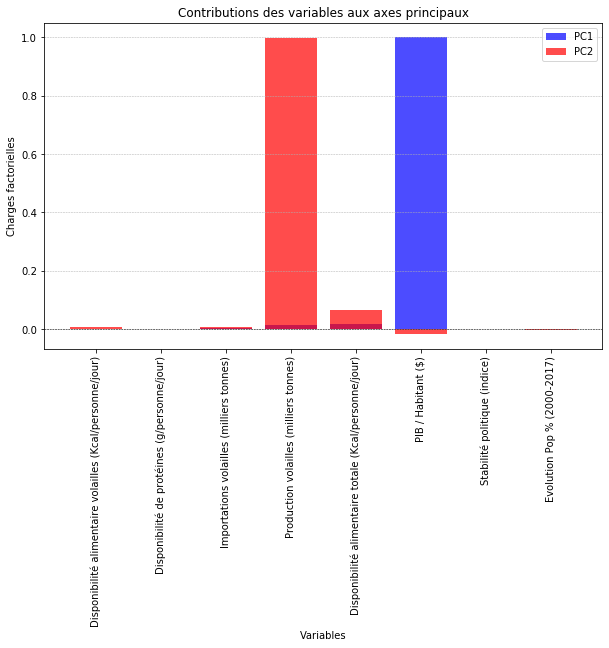

In [14]:
# Obtention des charges factorielles pour chaque variable (contributions aux axes principaux)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=variables.columns)

# Visualisation des contributions des variables aux axes principaux
plt.figure(figsize=(10, 6))
plt.bar(loadings.index, loadings['PC1'], label='PC1', color='b', alpha=0.7)
plt.bar(loadings.index, loadings['PC2'], label='PC2', color='r', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.xlabel('Variables')
plt.ylabel('Charges factorielles')
plt.title('Contributions des variables aux axes principaux')
plt.xticks(rotation=90)
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()


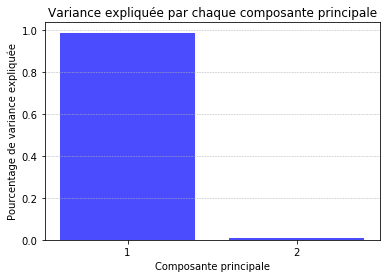

In [15]:
# Variance expliquée par chaque composante
explained_variance_ratio = pca.explained_variance_ratio_

# Visualisation du pourcentage de variance expliquée par chaque composante
plt.figure(figsize=(6, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, color='b', alpha=0.7)
plt.xlabel('Composante principale')
plt.ylabel('Pourcentage de variance expliquée')
plt.title('Variance expliquée par chaque composante principale')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()
